In [1]:
# mount drive
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
MyDrive  Shareddrives


In [2]:
# Get PSAW related imports
!pip install psaw
from psaw import PushshiftAPI
import datetime as dt
import pandas as pd

api = PushshiftAPI()


In [3]:
default_subreddits = ["AskReddit","announcements","funny","pics","todayilearned","science","IAmA","blog","videos","worldnews","gaming","movies","Music","aww","news","gifs","askscience","explainlikeimfive","EarthPorn","books","television","LifeProTips","sports","DIY","Showerthoughts","space","Jokes","tifu","food","photoshopbattles","Art","InternetIsBeautiful","mildlyinteresting","GetMotivated","history","nottheonion","gadgets","dataisbeautiful","Futurology","Documentaries","listentothis","personalfinance","philosophy","nosleep","creepy","OldSchoolCool","UpliftingNews","WritingPrompts","TwoXChromosomes"]


In [4]:
load_from_file = True
load_from_api = False
if load_from_file:
    # lala
    !cp "/gdrive/My Drive/colab_files/final/reddit_data_2020.csv" "reddit_data_2020.csv"
    posts_default_pastyear = pd.read_csv("reddit_data_2020.csv")
elif load_from_api:
    req = api.search_submissions(after=one_year_ago,
                                subreddit=default_subreddits,
                                score=">10")
    posts_default_pastyear = [post.d_ for post in req]
    posts_default_pastyear = pd.DataFrame(posts_default_pastyear)
    posts_default_pastyear = posts_default_pastyear[["title", "score", "subreddit", "created_utc"]]

    posts_default_pastyear.to_csv('reddit_data_short.csv')
    !cp "reddit_data.csv" "/gdrive/My Drive/colab_files/final/"

In [5]:

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

posts_default_pastyear = posts_default_pastyear.dropna()
posts_default_pastyear["score"] = posts_default_pastyear["score"].astype(float)
# do binary mapping later
#posts_default_pastyear["score"] = [1 if x > 100 else 0 for x in posts_default_pastyear["score"]]

print(posts_default_pastyear.shape)
print(posts_default_pastyear[["title", "score", "subreddit"]].sort_values("score", ascending=False).head(10))

sample_data = posts_default_pastyear[["title", "score"]]



(287509, 5)
                                                    title     score          subreddit
172736                            At a protest in Arizona  217126.0               pics
150058         This is the worst picture ever taken of me  160148.0               pics
168274  This man saved our dog. You can see our cat ju...  155424.0               pics
227910  Made her a bridge to the window she always sta...  147282.0                aww
162619  Scottish Parliament votes for immediate suspen...  142729.0          worldnews
236098  Due to less air pollution we now can actually ...  138408.0              funny
159306                                       I love money  135845.0             gaming
233168  I bought some suspiciously perfect bananas yes...  134622.0  mildlyinteresting
169580                                  A friendly Lizard  132406.0              funny
52003   There is a challenge where you put your hand n...  131320.0                aww


In [6]:
from torch.utils.data import TensorDataset, random_split
import numpy as np

class_size = 10000

class1_data = sample_data[sample_data["score"] <= 1000]
class0_data = class1_data[class1_data["score"] <= 100]
class1_data = class1_data[class1_data["score"] > 100]
class2_data = sample_data[sample_data["score"] > 1000]

print(class0_data.shape)
print(class1_data.shape)
print(class2_data.shape)

class0_data = class0_data.sample(class_size)
class1_data = class1_data.sample(class_size)
class2_data = class2_data.sample(class_size)

print(class0_data.shape)
print(class1_data.shape)
print(class2_data.shape)

new_data = pd.concat([class0_data, class1_data, class2_data])
print(new_data.shape)
new_data = new_data.sample(frac=1)
print(new_data.shape)
print(new_data.tail())

sample_data = new_data


(251957, 2)
(25002, 2)
(10550, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(30000, 2)
(30000, 2)
                                                    title   score
122781  My wife took some photos of her sister’s kitte...  2642.0
283755                He just wants to help you work out!  9189.0
128238                    Plz help I think I broke my cat    12.0
15649               I did it: I reported my abuser today.   122.0
245701                                           Mr Jesus  3263.0


In [7]:
# Transformers/BERT imports/init
!pip install transformers

In [8]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", do_lower_case=True)

In [9]:
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Version', torch.__version__)
print('CUDA enabled:', use_cuda)


Version 1.10.0+cu111
CUDA enabled: True


In [10]:
titles = sample_data.title.values
labels = sample_data.score.values

#print(labels[50:70])
#labels = [[0, 1] if l > 100 else [1, 0] for l in labels]
new_labels = []
for l in labels:
    if l < 100:
        new_labels.append([1, 0, 0])
    elif l < 1000:
        new_labels.append([0, 1, 0])
    else:
        new_labels.append([0, 0, 1])
labels = new_labels

#labels = [1 if l > 100 else 0 for l in labels]
#print(labels[50:70])

counts = [0, 0, 0]
for label in labels:
  counts[label.index(1)] += 1
for i, count in enumerate(counts):
  print('label ' + str(i + 1), ' count: ', str(count))
  print("label " + str(i + 1), ' percent: ', str(count / len(labels) * 100))


print(' Original: ', titles[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(titles[0]))

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(titles[0])))

print('Encoded:   ', tokenizer.encode(titles[0]))


label 1  count:  9992
label 1  percent:  33.306666666666665
label 2  count:  10006
label 2  percent:  33.35333333333333
label 3  count:  10002
label 3  percent:  33.339999999999996
 Original:  I still think about this video at least once a week.
Tokenized:  ['i', 'still', 'think', 'about', 'this', 'video', 'at', 'least', 'once', 'a', 'week', '.']
Token IDs:  [1045, 2145, 2228, 2055, 2023, 2678, 2012, 2560, 2320, 1037, 2733, 1012]
Encoded:    [101, 1045, 2145, 2228, 2055, 2023, 2678, 2012, 2560, 2320, 1037, 2733, 1012, 102]


In [11]:
import traceback

max_len = 0

# For every sentence...
for i, title in enumerate(titles):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(title, add_special_tokens=True)
    
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

# use 128

Max sentence length:  116


In [12]:
print(titles[0])

I still think about this video at least once a week.


In [13]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for title in titles:
    # `encode_plus` will:
    #   (1) Tokenize the title.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        title,                     # Title to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,          # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels).type(torch.FloatTensor)

# Print sentence 0, now as a list of IDs.
print('Original: ', titles[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I still think about this video at least once a week.
Token IDs: tensor([ 101, 1045, 2145, 2228, 2055, 2023, 2678, 2012, 2560, 2320, 1037, 2733,
        1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


In [14]:
print(labels[0])

tensor([0., 0., 1.])


In [15]:
from torch.utils.data import TensorDataset, random_split
import numpy as np

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create an 80-10-10 train-validation-test split
sizes = [0, 0, 0]
sizes[0] = int(0.8 * len(dataset))
sizes[1] = int(0.1 * len(dataset))
sizes[2] = len(dataset) - sizes[0] - sizes[1]

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, sizes)

print('{:>5,} training samples'.format(sizes[0]))
print('{:>5,} validation samples'.format(sizes[1]))
print('{:>5,} test samples'.format(sizes[2]))


24,000 training samples
3,000 validation samples
3,000 test samples


In [16]:
c = [0, 0, 0]
for point in dataset:
    c[np.argmax(point[2]).item()] += 1
    
print(c)

[9992, 10006, 10002]


In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
    train_dataset,  # The training samples.
    sampler = RandomSampler(train_dataset), # Select batches randomly
    batch_size = batch_size # Trains with this batch size.
)

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
    val_dataset, # The validation samples.
    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
    batch_size = batch_size # Evaluate with this batch size.
)

test_dataloader = DataLoader(
    test_dataset,
    sampler = SequentialSampler(test_dataset),
    batch_size=batch_size
)


In [18]:
from transformers import BertModel
from transformers import BertForSequenceClassification, BertConfig
import torch.nn as nn

class Net(torch.nn.Module): 
    def __init__(self, drop_rate=0.2): 
        super(Net, self).__init__() 
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for p in self.bert.parameters():
            p.requires_grad = False
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(768, 1)
        )

    def forward(self, input, mask):
        _, output = self.bert(input, attention_mask=mask, return_dict=False)
        output = self.regressor(output)
        return output
        
#regression_model = Net()

classification_model = BertForSequenceClassification.from_pretrained(
          "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
          num_labels = 3, # The number of output labels--2 for binary classification.
          output_attentions = False, # Whether the model returns attentions weights.
          output_hidden_states = False, # Whether the model returns all hidden-states.
)
classification_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [19]:
from transformers import AdamW
optimizer = AdamW(classification_model.parameters(),
                  lr = 5e-5, # default is 5e-5
                  eps = 1e-8 # default is 1e-8
                 )

In [20]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# 4 may be over-fitting the training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [21]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [22]:
def train_regression(model, optimizer, scheduler, loss_function, epochs,       
          train_dataloader, validation_dataloader, device, clip_value=1.0):
    training_stats = {"step_loss": [], "val_loss": [], "val_r2": []}

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # Measure how long the training epoch takes.
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}")

        # Training
        t0 = time.time()
        best_loss = 1e10
        total_epoch_loss = 0
        rolling_epoch_loss = 0

        model.train()
        for step, batch in enumerate(train_dataloader):
            if step % 40 == 0 and not step == 0:
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), format_time(time.time() - t0)))

            batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
            model.zero_grad()

            outputs = model(batch_inputs, batch_masks)           
            loss = loss_function(outputs.squeeze(), batch_labels.squeeze())

            total_epoch_loss += loss.item()
            rolling_epoch_loss += loss.item()
            if step % 40 == 0 and not step == 0:
                training_stats["step_loss"].append(rolling_epoch_loss / 40)
                print(f"  Avg batch loss is {rolling_epoch_loss / 40}")
                rolling_epoch_loss = 0

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()

        
        avg_train_loss = total_epoch_loss / len(train_dataloader)
        training_time = format_time(time.time() - t0)

        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

        t0 = time.time()

        # Validation
        val_loss, val_r2 = evaluate_regression(model, loss_function, validation_dataloader, device)
        training_stats["val_loss"].append(val_loss)
        training_stats["val_r2"].append(val_r2)

        avg_val_loss = np.mean(val_loss)
        validation_time = format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

    print()
                
    return training_stats

def evaluate_regression(model, loss_function, test_dataloader, device):
    model.eval()
    test_loss = 0
    test_r2 = 0
    for batch in test_dataloader:
        batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
            loss = loss_function(outputs.squeeze(), batch_labels.squeeze())
        
        test_loss += loss.item()
        test_r2 += r2_score(outputs, batch_labels)
    return test_loss, test_r2

def r2_score(outputs, labels):
    outputs = torch.tensor(outputs).type(torch.FloatTensor)
    labels = torch.tensor(labels).type(torch.FloatTensor)
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2


In [32]:
def train_classifier(model, optimizer, scheduler, epochs, train_dataloader,
                     validation_dataloader, device, clip_value=1.0):
    training_stats = {"step_loss": [], "val_loss": [], "val_acc": []}

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # initial eval
    init_loss, init_acc = evaluate_classifier(model, validation_dataloader, device)
    print("  Initial Loss: {0:.2f}".format(init_loss))
    print("  Initial Acc:  {0:.2f}".format(init_acc))

    # Measure how long the training epoch takes.
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}")

        # Training
        t0 = time.time()
        best_loss = 1e10
        total_epoch_loss = 0
        rolling_epoch_loss = 0

        model.train()
        for step, batch in enumerate(train_dataloader):
            if step % 40 == 0 and not step == 0:
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), format_time(time.time() - t0)))

            batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
            model.zero_grad()

            loss, logits = model(batch_inputs, 
                                 token_type_ids=None, 
                                 attention_mask=batch_masks, 
                                 labels=batch_labels,
                                 return_dict=False)

            total_epoch_loss += loss.item()
            rolling_epoch_loss += loss.item()
            if step % 40 == 0 and not step == 0:
                training_stats["step_loss"].append(rolling_epoch_loss / 40)
                print(f"  Avg batch loss is {rolling_epoch_loss / 40}")
                rolling_epoch_loss = 0

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
        
        avg_train_loss = total_epoch_loss / len(train_dataloader)
        training_time = format_time(time.time() - t0)

        print("  Average training loss: {0:.4f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

        # Validation
        t0 = time.time()
        val_loss, val_acc = evaluate_classifier(model, validation_dataloader, device)
        training_stats["val_loss"].append(val_loss)
        training_stats["val_acc"].append(val_acc)

        validation_time = format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.4f}".format(val_loss))
        print("  Validation Acc:  {0:.4f}".format(val_acc))
        print("  Validation took: {:}".format(validation_time))

    print()
                
    return training_stats

def evaluate_classifier(model, test_dataloader, device):
    model.eval()
    test_loss = 0
    test_acc = 0
    for batch in test_dataloader:
        batch_inputs, batch_masks, batch_labels = \
                                 tuple(b.to(device) for b in batch)

        with torch.no_grad():
            loss, logits = model(batch_inputs, 
                                 token_type_ids=None, 
                                 attention_mask=batch_masks, 
                                 labels=batch_labels,
                                 return_dict=False)
        test_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()

        test_acc += flat_accuracy(logits, label_ids)

    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader)
    
    return test_loss, test_acc

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = np.argmax(labels, axis=1).flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [24]:
#loss_function = nn.MSELoss()
#loss_function = nn.CrossEntropyLoss()

training_stats = train_classifier(classification_model, optimizer, scheduler, epochs,
                       train_dataloader, validation_dataloader, device)

test_loss, test_acc = evaluate_classifier(classification_model, test_dataloader, device)

print("Test Loss: {0:.2f}".format(test_loss))
print("Test Acc:  {0:.2f}".format(test_acc))


  Initial Loss: 0.66
  Initial Acc:  0.31
Epoch 1
  Batch    40  of    750.    Elapsed: 0:01:05.
  Avg batch loss is 0.6566499575972558
  Batch    80  of    750.    Elapsed: 0:02:10.
  Avg batch loss is 0.6365591675043106
  Batch   120  of    750.    Elapsed: 0:03:15.
  Avg batch loss is 0.6302739247679711
  Batch   160  of    750.    Elapsed: 0:04:20.
  Avg batch loss is 0.6269884943962097
  Batch   200  of    750.    Elapsed: 0:05:25.
  Avg batch loss is 0.6278804630041123
  Batch   240  of    750.    Elapsed: 0:06:30.
  Avg batch loss is 0.6314279779791832
  Batch   280  of    750.    Elapsed: 0:07:35.
  Avg batch loss is 0.6282473027706146
  Batch   320  of    750.    Elapsed: 0:08:39.
  Avg batch loss is 0.6254974141716957
  Batch   360  of    750.    Elapsed: 0:09:44.
  Avg batch loss is 0.6241099417209626
  Batch   400  of    750.    Elapsed: 0:10:49.
  Avg batch loss is 0.6201526880264282
  Batch   440  of    750.    Elapsed: 0:11:54.
  Avg batch loss is 0.6200444623827934
  Ba

In [25]:
print(training_stats)

{'step_loss': [0.6566499575972558, 0.6365591675043106, 0.6302739247679711, 0.6269884943962097, 0.6278804630041123, 0.6314279779791832, 0.6282473027706146, 0.6254974141716957, 0.6241099417209626, 0.6201526880264282, 0.6200444623827934, 0.6231630250811577, 0.6237949684262276, 0.6184008613228797, 0.6196055695414543, 0.6200686693191528, 0.6136069670319557, 0.6139664858579635, 0.6107266426086426, 0.5830206617712974, 0.5871567949652672, 0.5799291409552098, 0.5834251791238785, 0.5770518474280835, 0.5715190149843693, 0.5849314466118812, 0.5756293877959251, 0.5725854970514774, 0.5706725977361202, 0.5853719383478164, 0.5602418914437294, 0.5835353255271911, 0.5681729644536972, 0.5729239992797375, 0.5606008522212506, 0.5683114223182202], 'val_loss': [0.6272988072101106, 0.6367039598049001], 'val_acc': [0.40214982269503546, 0.42253989361702127]}


In [27]:
# Computing F1 scores instead of raw acc
def eval_F1(model, test_dataloader, device, classes):
  model.eval()
  f1scores = []
  for c in range(classes):
    # [tp, tn, fp, fn]
    f1scores.append([0] * 4)

  for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = \
                                tuple(b.to(device) for b in batch)
    with torch.no_grad():
      loss, logits = model(batch_inputs,
                            token_type_ids=None,
                            attention_mask=batch_masks,
                            labels=batch_labels,
                            return_dict=False)
      
    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()
    
    pred_flat = np.argmax(logits, axis=1).flatten()
    label_flat = np.argmax(label_ids, axis=1).flatten()
    for pred, label in zip(pred_flat, label_flat):
      for c in range(classes):
        if pred == c and label == c:
          # true positive
          f1scores[c][0] += 1
        elif pred == c and label != c:
          # false positive
          f1scores[c][2] += 1
        elif pred != c and label == c:
          # false negative
          f1scores[c][3] += 1
        else:
          # true negative
          f1scores[c][1] += 1

  output = []
  for c in range(classes):
    output.append(f1scores[c][0] / (f1scores[c][0] + 0.5 * (f1scores[c][1] + f1scores[c][2])))

  return output



In [28]:
f1scores = eval_F1(classification_model, test_dataloader, device, 3)
print(f1scores)

[0.3297587131367292, 0.20531113753468094, 0.34952722530159763]


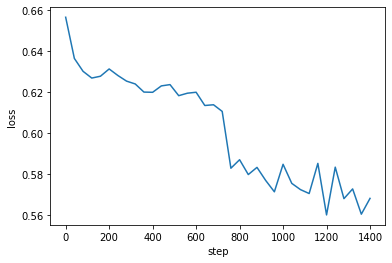

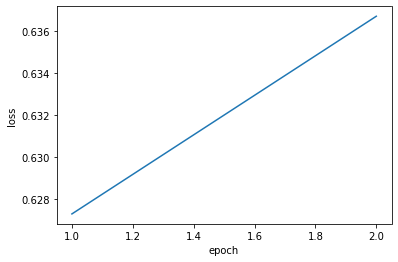

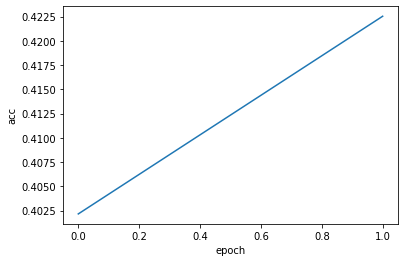

In [37]:
from numpy.lib.shape_base import vsplit
import matplotlib.pyplot as plt

#for val in training_stats["val_loss"]:
#    losses += val
#for val in training_stats["val_r2"]:
#    r2s += val

def plot_help(data, xlabel, ylabel, xscale=1, xoff=0):
    x = np.array(range(len(data))) * xscale + xoff
    plt.plot(x, data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
plot_help(training_stats["step_loss"], "step", "loss", 40)
plot_help(training_stats["val_loss"], "epoch", "loss", xoff=1)
plot_help(training_stats["val_acc"], "epoch", "acc")


In [30]:
training_stats2 = train_classifier(classification_model, optimizer, scheduler, 2,
                       train_dataloader, validation_dataloader, device)

test_loss2, test_acc2 = evaluate_classifier(classification_model, test_dataloader, device)

print("Test Loss: {0:.2f}".format(test_loss2))
print("Test Acc:  {0:.2f}".format(test_acc2))

  Initial Loss: 0.64
  Initial Acc:  0.42
Epoch 1
  Batch    40  of    750.    Elapsed: 0:01:05.
  Avg batch loss is 0.5342739403247834
  Batch    80  of    750.    Elapsed: 0:02:10.
  Avg batch loss is 0.5191659919917584
  Batch   120  of    750.    Elapsed: 0:03:15.
  Avg batch loss is 0.5220447219908237
  Batch   160  of    750.    Elapsed: 0:04:20.
  Avg batch loss is 0.5284428492188453
  Batch   200  of    750.    Elapsed: 0:05:24.
  Avg batch loss is 0.5157223217189312
  Batch   240  of    750.    Elapsed: 0:06:29.
  Avg batch loss is 0.5189887046813965
  Batch   280  of    750.    Elapsed: 0:07:34.
  Avg batch loss is 0.5257378712296485
  Batch   320  of    750.    Elapsed: 0:08:39.
  Avg batch loss is 0.5295469135046005
  Batch   360  of    750.    Elapsed: 0:09:44.
  Avg batch loss is 0.5192633837461471
  Batch   400  of    750.    Elapsed: 0:10:48.
  Avg batch loss is 0.5309652008116246
  Batch   440  of    750.    Elapsed: 0:11:53.
  Avg batch loss is 0.516742404550314
  Bat

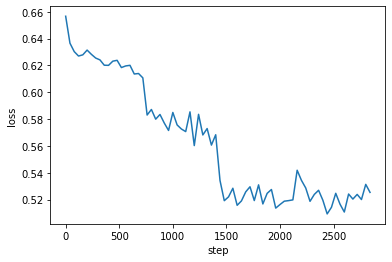

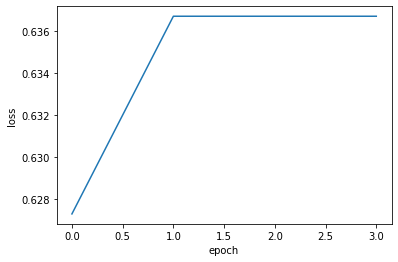

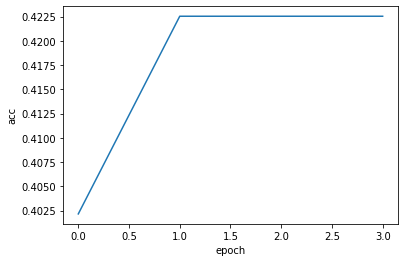

In [31]:
steploss = training_stats["step_loss"] + training_stats2["step_loss"]
valloss = training_stats["val_loss"] + training_stats2["val_loss"]
accuracy = training_stats["val_acc"] + training_stats2["val_acc"]

plot_help(steploss, "step", "loss", 40)
plot_help(valloss, "epoch", "loss")
plot_help(accuracy, "epoch", "acc")

In [33]:

optimizer = AdamW(classification_model.parameters(),
                  lr = 1e-5, # default is 5e-5
                  eps = 1e-8 # default is 1e-8
                 )

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# 4 may be over-fitting the training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

training_stats3 = train_classifier(classification_model, optimizer, scheduler, 2,
                       train_dataloader, validation_dataloader, device)

test_loss3, test_acc3 = evaluate_classifier(classification_model, test_dataloader, device)

print("Test Loss: {0:.4f}".format(test_loss3))
print("Test Acc:  {0:.4f}".format(test_acc3))

  Initial Loss: 0.64
  Initial Acc:  0.42
Epoch 1
  Batch    40  of    750.    Elapsed: 0:01:05.
  Avg batch loss is 0.5384556829929352
  Batch    80  of    750.    Elapsed: 0:02:09.
  Avg batch loss is 0.5283154405653476
  Batch   120  of    750.    Elapsed: 0:03:14.
  Avg batch loss is 0.5089309096336365
  Batch   160  of    750.    Elapsed: 0:04:19.
  Avg batch loss is 0.5348901338875294
  Batch   200  of    750.    Elapsed: 0:05:24.
  Avg batch loss is 0.5007794238626957
  Batch   240  of    750.    Elapsed: 0:06:28.
  Avg batch loss is 0.5100538283586502
  Batch   280  of    750.    Elapsed: 0:07:33.
  Avg batch loss is 0.506185857206583
  Batch   320  of    750.    Elapsed: 0:08:38.
  Avg batch loss is 0.5145819328725338
  Batch   360  of    750.    Elapsed: 0:09:42.
  Avg batch loss is 0.5010452210903168
  Batch   400  of    750.    Elapsed: 0:10:47.
  Avg batch loss is 0.5081954710185528
  Batch   440  of    750.    Elapsed: 0:11:51.
  Avg batch loss is 0.5092149518430233
  Bat

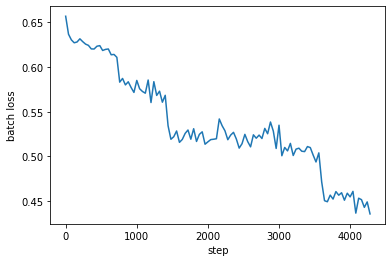

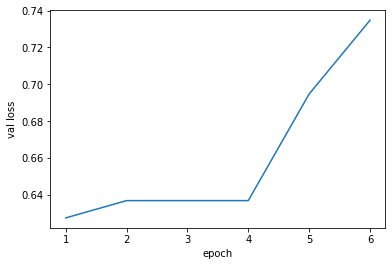

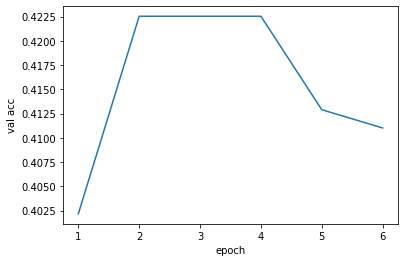

In [38]:
fullsteploss = training_stats["step_loss"] + training_stats2["step_loss"] + training_stats3["step_loss"]
fullvalloss = training_stats["val_loss"] + training_stats2["val_loss"] + training_stats3["val_loss"]
fullvalacc = training_stats["val_acc"] + training_stats2["val_acc"] + training_stats3["val_acc"]

plot_help(fullsteploss, "step", "batch loss", 40)
plot_help(fullvalloss, "epoch", "val loss", xoff=1)
plot_help(fullvalacc, "epoch", "val acc", xoff=1)